In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import os

# Ruta al dataset
df = pd.read_csv('../data/sales_data_sample.csv', encoding='latin1')

# Exploración básica
df.head(), df.info(), df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ORDERNUMBER       2823 non-null   int64  
 1   QUANTITYORDERED   2823 non-null   int64  
 2   PRICEEACH         2823 non-null   float64
 3   ORDERLINENUMBER   2823 non-null   int64  
 4   SALES             2823 non-null   float64
 5   ORDERDATE         2823 non-null   object 
 6   STATUS            2823 non-null   object 
 7   QTR_ID            2823 non-null   int64  
 8   MONTH_ID          2823 non-null   int64  
 9   YEAR_ID           2823 non-null   int64  
 10  PRODUCTLINE       2823 non-null   object 
 11  MSRP              2823 non-null   int64  
 12  PRODUCTCODE       2823 non-null   object 
 13  CUSTOMERNAME      2823 non-null   object 
 14  PHONE             2823 non-null   object 
 15  ADDRESSLINE1      2823 non-null   object 
 16  ADDRESSLINE2      302 non-null    object 


(   ORDERNUMBER  QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  \
 0        10107               30      95.70                2  2871.00   
 1        10121               34      81.35                5  2765.90   
 2        10134               41      94.74                2  3884.34   
 3        10145               45      83.26                6  3746.70   
 4        10159               49     100.00               14  5205.27   
 
          ORDERDATE   STATUS  QTR_ID  MONTH_ID  YEAR_ID  ...  \
 0   2/24/2003 0:00  Shipped       1         2     2003  ...   
 1    5/7/2003 0:00  Shipped       2         5     2003  ...   
 2    7/1/2003 0:00  Shipped       3         7     2003  ...   
 3   8/25/2003 0:00  Shipped       3         8     2003  ...   
 4  10/10/2003 0:00  Shipped       4        10     2003  ...   
 
                     ADDRESSLINE1  ADDRESSLINE2           CITY STATE  \
 0        897 Long Airport Avenue           NaN            NYC    NY   
 1             59 rue de l'Abb

Columnas y tipos de datos:
 ORDERNUMBER           int64
QUANTITYORDERED       int64
PRICEEACH           float64
ORDERLINENUMBER       int64
SALES               float64
ORDERDATE            object
STATUS               object
QTR_ID                int64
MONTH_ID              int64
YEAR_ID               int64
PRODUCTLINE          object
MSRP                  int64
PRODUCTCODE          object
CUSTOMERNAME         object
PHONE                object
ADDRESSLINE1         object
ADDRESSLINE2         object
CITY                 object
STATE                object
POSTALCODE           object
COUNTRY              object
TERRITORY            object
CONTACTLASTNAME      object
CONTACTFIRSTNAME     object
DEALSIZE             object
dtype: object

Valores nulos por columna:
 ORDERNUMBER            0
QUANTITYORDERED        0
PRICEEACH              0
ORDERLINENUMBER        0
SALES                  0
ORDERDATE              0
STATUS                 0
QTR_ID                 0
MONTH_ID               0
YEAR

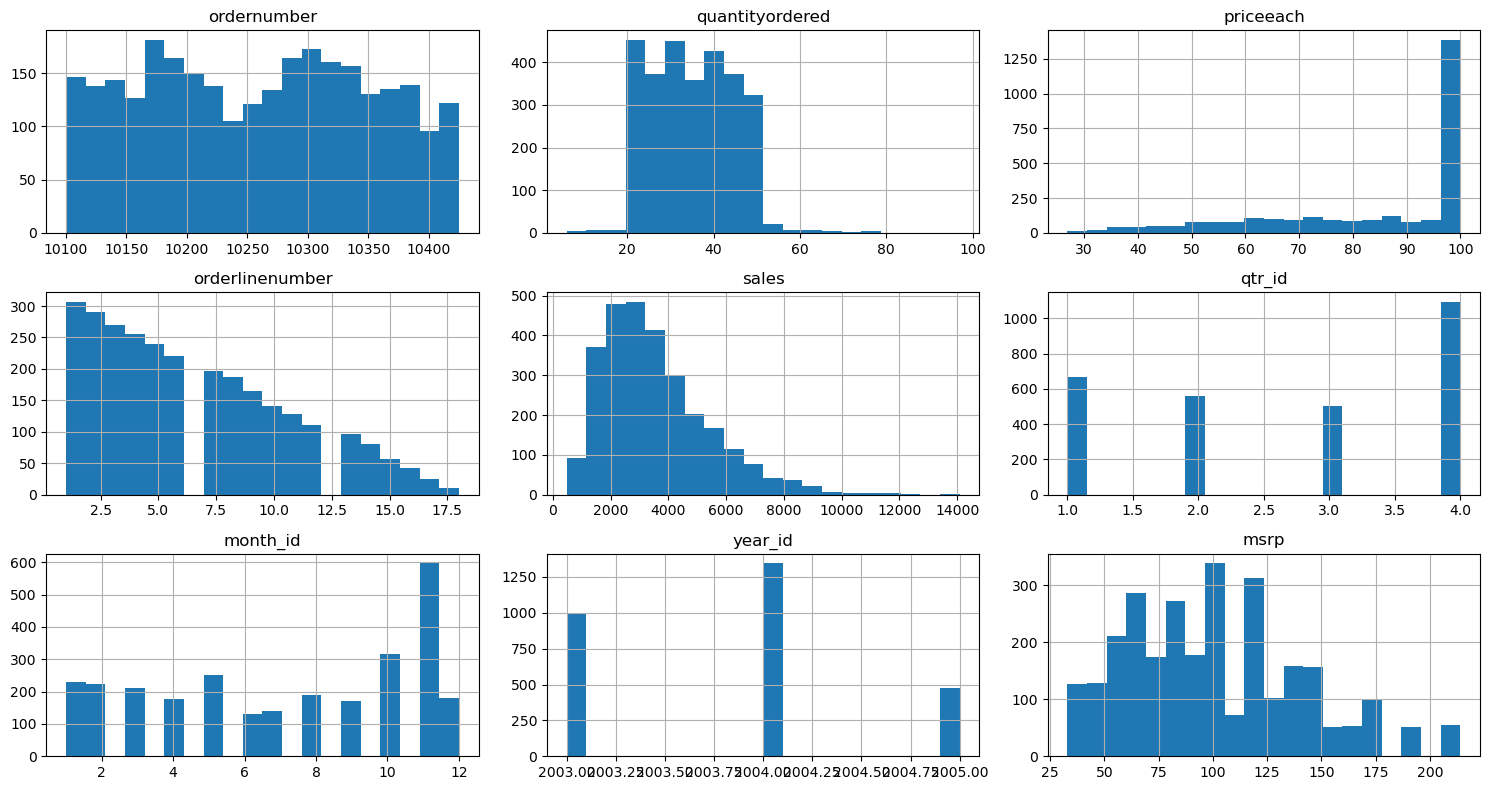

In [2]:
# --- 1. Visualizar columnas y detectar datos faltantes ---
print("Columnas y tipos de datos:\n", df.dtypes)
print("\nValores nulos por columna:\n", df.isnull().sum())

# --- 2. Estandarizar nombres de columnas ---
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# --- 3. Revisar duplicados ---
print("\nDuplicados encontrados:", df.duplicated().sum())
df.drop_duplicates(inplace=True)

# --- 4. Conversión de tipos de datos ---
# Convertir fecha a tipo datetime
if 'orderdate' in df.columns:
    df['orderdate'] = pd.to_datetime(df['orderdate'], errors='coerce')

# --- 5. Generar variables adicionales desde fechas ---
if 'orderdate' in df.columns:
    df['ano'] = df['orderdate'].dt.year
    df['mes'] = df['orderdate'].dt.month
    df['dia_semana'] = df['orderdate'].dt.day_name()

# --- 6. Imputación si hay valores nulos (opcional, según el análisis) ---
# Aquí puedes imputar si hay columnas con pocos nulos
# Por ejemplo:
# df['price_each'].fillna(df['price_each'].median(), inplace=True)

# --- 7. Visualización básica para verificar distribución de datos numéricos ---
df.describe()

# --- 8. Histograma de algunas variables ---
variables_numericas = df.select_dtypes(include=['float64', 'int64']).columns
df[variables_numericas].hist(bins=20, figsize=(15, 8))
plt.tight_layout()
plt.show()

In [3]:
# Eliminamos columnas poco útiles
df.drop(columns=['addressline2'], inplace=True)

# Imputamos postalcode por ciudad
df['postalcode'] = df.groupby('city')['postalcode'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else '00000'))

# Imputamos territory
df['territory'] = df['territory'].fillna('No asignado')

# Imputar por país
df['state'] = df['state'].fillna(
    df.groupby('country')['state'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
)

# Luego completar los que siguen nulos
df['state'] = df['state'].fillna('No asignado')

print("Valores nulos restantes en 'state':", df['state'].isna().sum())
print("Valores 'No asignado':", (df['state'] == 'No asignado').sum())

print("\nValores nulos por columna:\n", df.isnull().sum())


Valores nulos restantes en 'state': 0
Valores 'No asignado': 1368

Valores nulos por columna:
 ordernumber         0
quantityordered     0
priceeach           0
orderlinenumber     0
sales               0
orderdate           0
status              0
qtr_id              0
month_id            0
year_id             0
productline         0
msrp                0
productcode         0
customername        0
phone               0
addressline1        0
city                0
state               0
postalcode          0
country             0
territory           0
contactlastname     0
contactfirstname    0
dealsize            0
ano                 0
mes                 0
dia_semana          0
dtype: int64


Columnas numéricas:
 ['ordernumber', 'quantityordered', 'priceeach', 'orderlinenumber', 'sales', 'qtr_id', 'month_id', 'year_id', 'msrp']


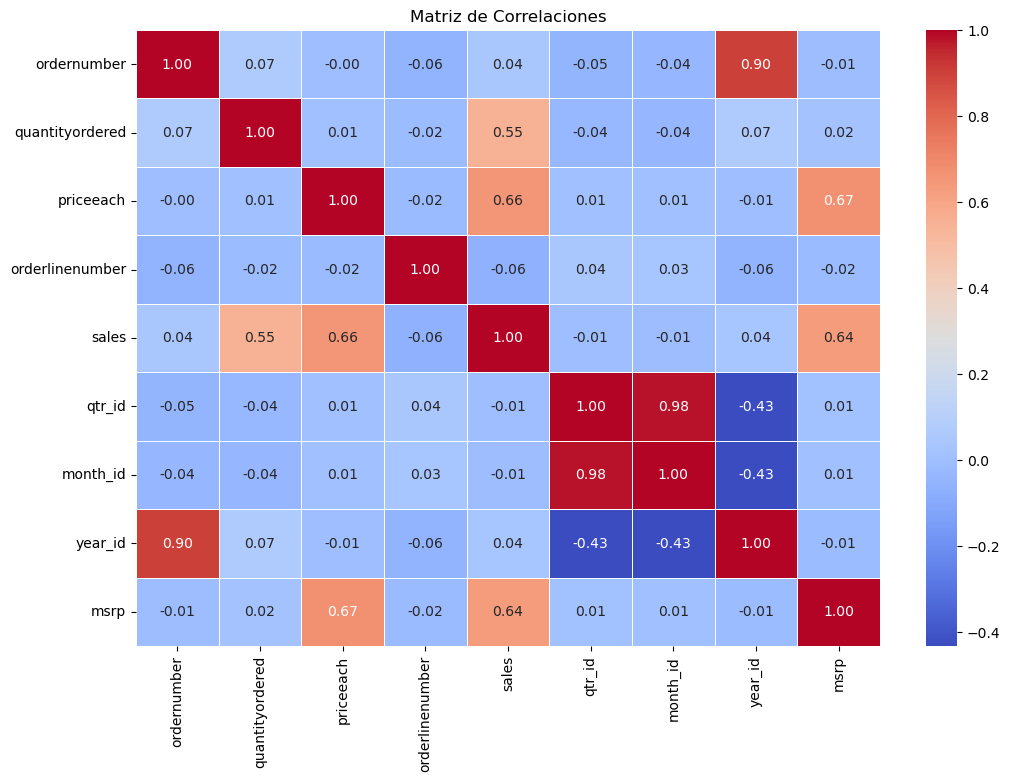

Correlaciones con sales :
 priceeach          0.657841
msrp               0.635239
quantityordered    0.551426
ordernumber        0.039919
year_id            0.035647
qtr_id            -0.006796
month_id          -0.009605
orderlinenumber   -0.058400
Name: sales, dtype: float64


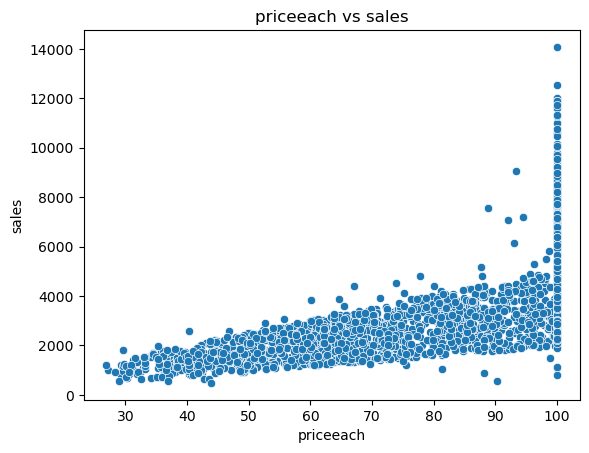

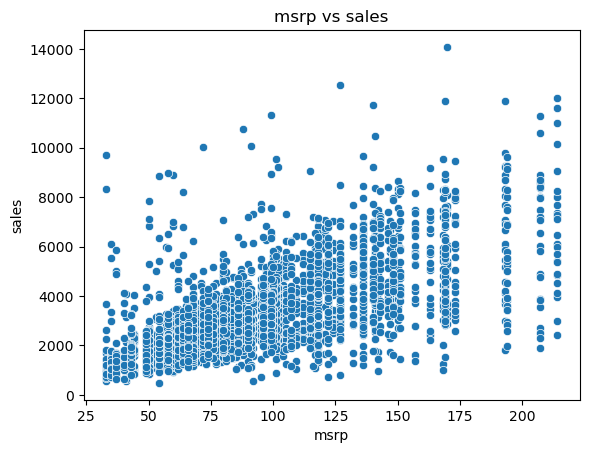

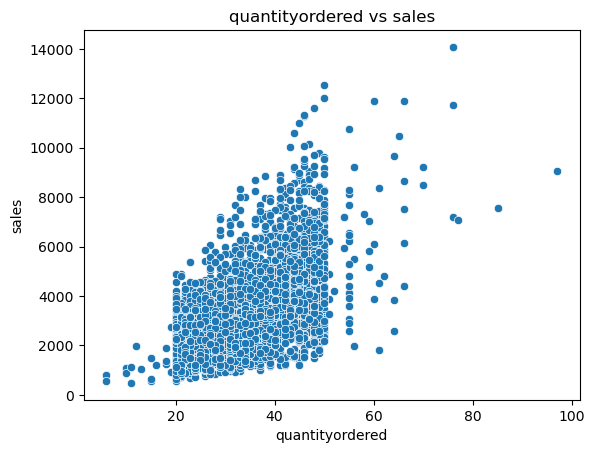

In [4]:
# Seleccionar solo columnas numéricas
df_numericas = df.select_dtypes(include=['int64', 'float64'])

# Mostrar nombres de columnas numéricas
print("Columnas numéricas:\n", df_numericas.columns.tolist())

# Matriz de correlación
corr = df_numericas.corr()

# Visualización con heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlaciones')
plt.show()

# Correlaciones con la variable objetivo
objetivo = 'sales'  # Cambia si tu variable se llama diferente
correlaciones_objetivo = corr[objetivo].drop(objetivo).sort_values(ascending=False)
print("Correlaciones con", objetivo, ":\n", correlaciones_objetivo)


# Gráfico de dispersión entre variables más correlacionadas
mejores_vars = correlaciones_objetivo[abs(correlaciones_objetivo) > 0.3].index.tolist()

for var in mejores_vars:
    sns.scatterplot(data=df, x=var, y=objetivo)
    plt.title(f'{var} vs {objetivo}')
    plt.show()


In [5]:
# -------------------------------
# 1. Definir variables
# -------------------------------
features = ['priceeach', 'msrp', 'quantityordered', 'productline', 'city', 'territory']
target = 'sales'

X = df[features]
y = df[target]

numeric_features = ['priceeach', 'msrp', 'quantityordered']
categorical_features = ['productline', 'city', 'territory']

# -------------------------------
# 2. Transformadores
# -------------------------------
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# -------------------------------
# 3. Split de datos
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -------------------------------
# 4. Regresión Lineal con pipeline
# -------------------------------
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

# ✅ Calcular RMSE manualmente
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)

# ✅ Calcular R²
r2_lr = r2_score(y_test, y_pred_lr)

print("🔍 Regresión Lineal")
print(f"RMSE: {rmse_lr:.2f}")
print(f"R²: {r2_lr:.4f}")

# -------------------------------
# 5. Random Forest con pipeline
# -------------------------------
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(
        random_state=42,
        max_depth=10,
        min_samples_leaf=2,
        min_samples_split=10,
        n_estimators=100
    ))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

# ✅ Calcular RMSE manualmente
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

# ✅ Calcular R²
r2_rf = r2_score(y_test, y_pred_rf)

print('-'*50)
print("🌲 Random Forest")
print(f"RMSE: {rmse_rf:.2f}")
print(f"R²: {r2_rf:.4f}")

# -------------------------------
# 6. Predicción sobre todo el dataset
# -------------------------------
df['sales_pred_rf'] = rf_pipeline.predict(X)

# -------------------------------
# 7. Exportar a Power BI
# -------------------------------

# Redondear a dos decimales como en la columna real 'sales'
df['sales_pred_rf'] = df['sales_pred_rf'].round(2)
df['error_prediccion'] = df['sales_pred_rf'] - df['sales']
df['error_prediccion'] = df['error_prediccion'].round(2)
df['porcentaje_error_prediccion'] = (df['error_prediccion'] / df['sales'])
df['porcentaje_error_prediccion'] = df['porcentaje_error_prediccion'].round(2)

columnas_exportar = [
    'ordernumber',
    'orderdate',
    'city', 'state', 'territory', 'postalcode',
    'productcode', 'productline',
    'quantityordered', 'priceeach', 'msrp',
    'sales', 'sales_pred_rf',
    'ano', 'mes', 'dia_semana', 'error_prediccion',
    'porcentaje_error_prediccion'
]

# Verificar que las columnas existan
columnas_finales = [col for col in columnas_exportar if col in df.columns]
df_powerbi = df[columnas_finales]

# Guardar archivo
os.makedirs('../outputs', exist_ok=True)
df_powerbi.to_csv('../outputs/datos_para_powerbi.csv', index=False)

🔍 Regresión Lineal
RMSE: 1025.62
R²: 0.7590
--------------------------------------------------
🌲 Random Forest
RMSE: 704.69
R²: 0.8862


In [6]:
# Validacion de las predicciones
print(df[['sales', 'sales_pred_rf', 'error_prediccion', 'porcentaje_error_prediccion']].head(10))

     sales  sales_pred_rf  error_prediccion  porcentaje_error_prediccion
0  2871.00        2846.91            -24.09                        -0.01
1  2765.90        2801.47             35.57                         0.01
2  3884.34        3824.73            -59.61                        -0.02
3  3746.70        3752.34              5.64                         0.00
4  5205.27        5436.68            231.41                         0.04
5  3479.76        3477.43             -2.33                        -0.00
6  2497.77        2490.19             -7.58                        -0.00
7  5512.32        5370.72           -141.60                        -0.03
8  2168.54        2155.07            -13.47                        -0.01
9  4708.44        4750.95             42.51                         0.01
